# Cubic spline distribution

This describes the cubic spline used in Pyro's [SIR HMC example](https://pyro.ai/examples/sir_hmc.html).

In [1]:
import torch
import matplotlib.pyplot as plt

%matplotlib inline

Let's define a cubic polynomial and hand-compute its derivatives (we could alternatively do this in SymPy).

In [2]:
def cubic(t, deriv=0):
    if deriv == -1:
        return torch.tensor([t, t**2/2, t**3/3, t**4/4])
    if deriv == 0:
        return torch.tensor([1., t, t**2, t**3])
    if deriv == 1:
        return torch.tensor([0., 1., 2 * t, 3*t**2])
    if deriv == 2:
        return torch.tensor([0., 0., 2., 6*t])

Next let's solve a constraint problem set up as a linear system of equations. We'll assume our cubic spline has four parts but is symmetric, so we can wlog consider only two of those parts, say `f` and `g`, where
```
spline(t) = { f(t)   if 0 <= t <= 1
              g(2-t) if 1 <= t <= 2
              g(t-2) if 2 <= t <= 3
              f(4-t) if 3 <= t <= 4
              0      otherwise
```

In [3]:
# We'll build up a set of linear equations.
vec = []
mat = []

def constrain(value, f=torch.zeros(4), g=torch.zeros(4)):
    vec.append(value)
    mat.append(torch.cat([f, g]))

# Ensure 0,1,2 derivatives are zero at t=0.
constrain(0., f=cubic(0))
constrain(0., f=cubic(0, deriv=1))
constrain(0., f=cubic(0, deriv=2))
# Ensure 0,1,2 derivates match at t=1.
constrain(0., f=cubic(1), g=-cubic(1))
constrain(0., f=cubic(1, deriv=1), g=cubic(1, deriv=1))
constrain(0., f=cubic(1, deriv=2), g=-cubic(1, deriv=2))
# Ensure 1st derivative matches at t=2.
# Note 0,2 derivs agreement is automatically satisfied by symmetry.
constrain(0., g=cubic(0, deriv=1))
# Finally constraint the total integral to unity (f+g+g+f = 1).
constrain(.5, f=cubic(1, deriv=-1), g=cubic(1, deriv=-1))

# Now we solve the linear system.
vec = torch.tensor(vec)
mat = torch.stack(mat)
print(mat)
coef = torch.solve(vec.unsqueeze(-1), mat)[0]

# And print the coefficients of f and g.
f_coef = coef[:4, 0]
g_coef = coef[4:, 0]
print(f_coef)
print(g_coef)

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  2.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [ 0.0000,  1.0000,  2.0000,  3.0000,  0.0000,  1.0000,  2.0000,  3.0000],
        [ 0.0000,  0.0000,  2.0000,  6.0000, -0.0000, -0.0000, -2.0000, -6.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [ 1.0000,  0.5000,  0.3333,  0.2500,  1.0000,  0.5000,  0.3333,  0.2500]])
tensor([0.0000, 0.0000, 0.0000, 0.1667])
tensor([ 6.6667e-01, -1.1921e-07, -1.0000e+00,  5.0000e-01])


Let's define these functions as polynomials and plo the result to sanity check.

In [4]:
def f(t):
    return t.unsqueeze(-1).pow(torch.arange(4.)).mul(f_coef).sum(-1)
def g(t):
    return t.unsqueeze(-1).pow(torch.arange(4.)).mul(g_coef).sum(-1)

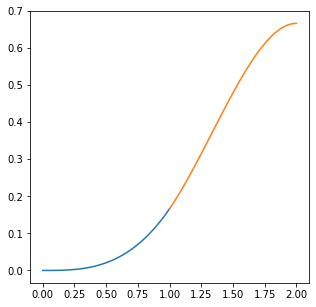

In [5]:
plt.figure(figsize=(5, 5)).patch.set_color("white")
t = torch.linspace(0., 1., 100)
plt.plot(t, f(t))
plt.plot(2 - t, g(t));

It looks like the coefficients are all fractions of 6:

In [6]:
print(f_coef * 6)
print(g_coef * 6)

tensor([0.0000, 0.0000, 0.0000, 1.0000])
tensor([ 4.0000e+00, -7.1526e-07, -6.0000e+00,  3.0000e+00])


Now testing the final implementation (note the order of splines is reversed from the implementation in `sir_hmc.quantize()` because here we are plotting, whereas there we are interpolating).

In [7]:
def quantize(x_real):
    lb = x_real.detach().floor()
    s = x_real - lb
    ss = s * s
    t = 1 - s
    tt = t * t
    probs = torch.stack([
        s * ss,
        4 + tt * (3 * t - 6),
        4 + ss * (3 * s - 6),
        t * tt,
    ], dim=-1) / 6
    return probs

Let's see how the basis weights evolve through the unit interval.

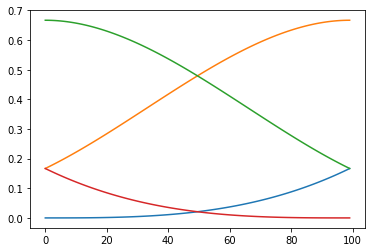

In [8]:
plt.plot(quantize(t * 0.9999));

And visualizing the influence of a single grid point:

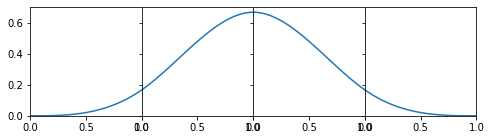

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(8, 2), sharey=True)
fig.patch.set_color("white")
for part, ax in zip(quantize(t * 0.9999).T, axes):
    ax.plot(t, part)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.7)
plt.subplots_adjust(wspace=0)